The Breeden-Litzenberger formula is a fundamental result in quantitative finance. It shows that the probability density function (PDF) of a future asset price under the risk-neutral measure ($\mathbb{Q}$) is directly linked to the second partial derivative of European call option prices with respect to the strike price.

The price of a European call option $C(K,T)$ with strike $K$ and maturity $T$ is the discounted expected value of its payoff under the risk-neutral measure $\mathbb{Q}$:
$$
C(K,T)=e^{-rT}\mathbb{E}_{\mathbb{Q}}[\max(S_T-K,0)] = e^{-rT}\int_K^{\infty}(S_T-K)f_Q(S_T)dS_T​
$$

To isolate the density, we need to differentiate the integral twice.

Let’s take the first partial derivative of the call price with respect to the strike $K$:
$$
\frac{\partial C}{\partial K}=e^{-rT}\frac{\partial}{\partial K}\int_K^{\infty}(S_T-K)f_Q(S_T)dS_T​ = e^{-rT}\left[\int_K^{\infty}​(-1)f_Q(S_T)dS_T - (K-K)f_Q(K)\right] = -e^{-rT}\int_K^{\infty}​f_Q(S_T)dS_T​
$$

Note: this represents $−e^{-rT}$ multiplied by the risk-neutral probability that the option expires in-the-money $(S_T​>K)$, or the CDF.

Now, we differentiate with respect to $K$ a second time.
$$
\frac{\partial^2 C}{\partial K^2} = -e^{-rT}\frac{\partial}{\partial K}\int_K^{\infty}​f_Q(S_T)dS_T​ = -e^{-rT}[-f_Q(K)]
$$

Which gives us the final formula for the risk-neutral density:
$$
f_Q(K)=e^{rT}\frac{\partial^2 C}{\partial K^2}
$$

This formula is **model-agnostic**. It doesn't matter if the market follows Black-Scholes or a stochastic volatility model; if you have a smooth call surface, you can extract the market's implied probability distribution.

#### Butterfly Spread
In practice, the second derivative is approximated using a *Butterfly Spread*. If you buy a call at $K−\Delta K", sell two at $K$, and buy one at $K+\Delta K$, the payoff resembles a spike at $K$.

If you have a perfectly smooth, continuous call price function, a simple numerical derivative would be the path of least resistance. However, the market rarely hands us a clean curve; it gives us a scattered set of discrete data points.

The Breeden-Litzenberger formula states that the state price density is proportional to the second derivative of the call price $C$ with respect to the strike $K$; in a purely numerical sense, the second derivative is defined as:
$$
\frac{\partial^2 C}{\partial K^2} = \frac{C(K+\Delta K)-2C(K)+C(K-\Delta K)​}{\Delta K^2}
$$



Breeden-Litzenberger and Smile

The "Smile" is a plot of Implied Volatility ($\sigma_{imp}$​) against the Strike Price ($K$). In Black-Scholes the assumption is a log-normal distribution, which implies a flat volatility line. In reality the distribution of asset returns usually has "fat tails" (kurtosis) and skewness.

Because $f_Q​(K)=e^{rT}\frac{\partial^2 C}{\partial K^2}$​, the shape of the probability density function is directly encoded in the curvature of the option price surface.

If we express the call price as a function of implied volatility $C(K,\sigma(K))$, the second derivative $\frac{\partial^2 C}{\partial K^2}$ becomes quite complex because $\sigma$ itself depends on $K$.

If the smile has a downward slope (Equity Skew), the PDF is skewed to the left. This indicates the market assigns a higher probability to a large market crash than the Black-Scholes model predicts.

A higher curvature (a sharper "U" shape) indicates fat tails (excess kurtosis). This means the market expects "extreme" moves (either up or down) to happen more frequently than a normal distribution would suggest.

## Underlying PDF from Market Data

I tried the same exercise to compute the market implied risk-neutral densities for the S&P 500.

I have taken call option prices with the same maturity but different strikes on S&P 500 (other parameters are $T=1.6329$, $r=0.009779$, $S=1036.2$).

Essentially I repeated the steps above but adding a few more:
* I interpolated (with cubic-spline) the option prices, *increasing* the number of points of the PDF;
* I checked for strikes leading to negative density and in case I removed those points from the calculation (brute force approach), surely there are better ways to deal with that.

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline

def breeden_litzenberger(strikes, prices, r, T, dk=0.5):
    k_grid = np.arange(strikes.min(), strikes.max() + dk, dk)
    c_interp = interp1d(strikes, prices, kind='cubic')(k_grid)
    
    d2C_raw = np.gradient(np.gradient(c_interp, dk), dk)
    clean_mask = d2C_raw >= 0
    k_clean = k_grid[clean_mask]
    c_clean = c_interp[clean_mask]

    if len(k_clean) < len(k_grid):
        print(f"Removed {len(k_grid) - len(k_clean)} points due to butterfly arbitrage.")
    
    spline_clean = UnivariateSpline(k_clean, c_clean, k=4, s=0.5)
    
    density = spline_clean.derivative(n=2)(k_grid) * np.exp(r * T)
    density = np.maximum(density, 0)
    poly = np.polynomial.polynomial.Polynomial.fit(k_grid, density, 7)    
    return k_grid, density, c_interp, d2C_raw, ~clean_mask, clean_mask, poly

T = 1.6329
r = 0.009779
q = 0.02208
S0 = 1036.2

strikes = np.array([650, 700, 750, 800, 850, 900, 950, 975, 1000, 1025,
                    1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225,
                    1250, 1275, 1300, 1325, 1350, 1375, 1400, 1450, 1500,
                    1550, 1600, 1650, 1700, 1800])
prices = np.array([387.5, 346.45, 306.8, 268.95, 232.85, 199.15, 168.1,
                   153.7, 139.9, 126.15, 112.9, 100.7, 89.45, 79.25, 69.7,
                   60.8, 52.8, 45.8, 39.6, 33.9, 28.85, 24.4, 20.6, 17.3,
                   13.35, 9.25, 6.55, 4.2, 2.65, 1.675, 1.125, 0.575])

vols = np.array([0.337024, 0.325662, 0.313846, 0.302428, 0.290759, 0.279979, 0.270041, 0.265506, 0.260885, 0.255063, 0.248928,
                 0.243514, 0.238585, 0.234326, 0.229944, 0.22543, 0.221322, 0.21791, 0.21486, 0.21154, 0.208372, 0.205328,
                 0.202698, 0.200198, 0.193611, 0.190194, 0.188604, 0.184105, 0.180255, 0.177356, 0.176491, 0.177828])

in_strikes, in_prices, c, d2C, arb_indices, no_arb_indices, polynomial = breeden_litzenberger(strikes, prices, r, T, dk=0.5)

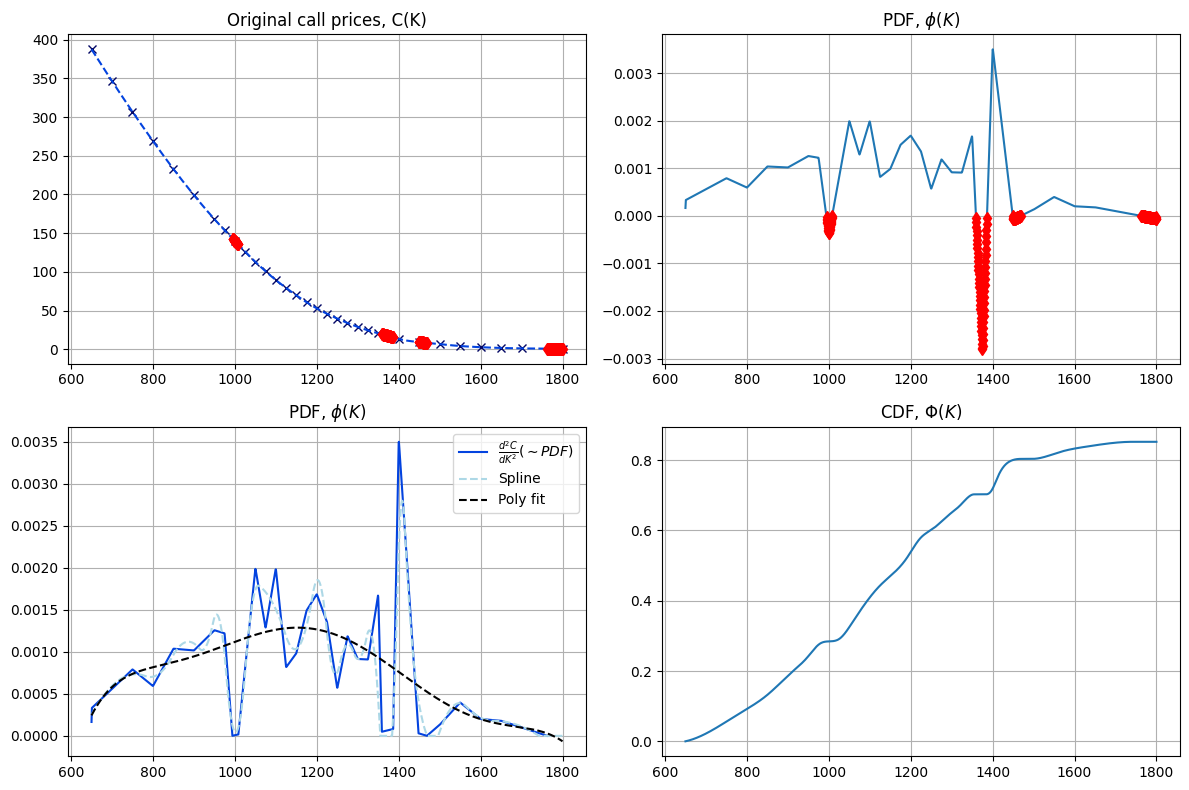

In [53]:
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(strikes, prices, 'x', color="xkcd:darkblue")
plt.plot(in_strikes, c, color='xkcd:blue', linestyle="--")
plt.plot(in_strikes[arb_indices], c[arb_indices], 'rd')
plt.grid(True)
plt.title('Original call prices, C(K)')

plt.subplot(222)
plt.plot(in_strikes, d2C)
plt.plot(in_strikes[arb_indices], d2C[arb_indices], 'rd')
plt.grid(True)
plt.title(r'PDF, $\phi(K)$')

plt.subplot(223)
plt.plot(in_strikes[no_arb_indices], d2C[no_arb_indices], label=r"$\frac{d^2C}{dK^2} (\sim PDF)$", color='xkcd:blue')
plt.plot(in_strikes, in_prices, label="Spline", color='lightblue', linestyle="--")
plt.plot(in_strikes, polynomial(in_strikes), label="Poly fit", color='black', linestyle="--")
plt.grid(True)
plt.title(r'PDF, $\phi(K)$')
plt.legend()

plt.subplot(224)
plt.plot(in_strikes, np.cumsum(in_prices*0.5))
plt.grid(True)
plt.title(r'CDF, $\Phi(K)$')

plt.tight_layout()
plt.show()


* (top-left) interpolated option prices, those highlighted in red are give negative PDF
* (top-right) resulting PDF, again red points show the negative part of the PDF
* (bottom-left) the PDF once the problematic strikes are removed. The dashed black line shows a polynomial fit of the PDF.
* (bottom-right) the corresponding CDF, also in this case it doesn't sum up to 1. Again the main reason being the truncated integration interval.

### Volatility Parametrization

To get a smoother result (also with an extended strike interval) it is possible to:
* determine the implied volatilities from the option prices;
* fit the volatility surface (or a slice like in this case) with the preferred model or with a suitable function;
* go back to the prices implied by the volatility fit;
* compute the second derivative of the obtained price distribution.

Below the code to invert the market prices (not used since the dataset had already the implied volatilities).

In [ ]:
import numpy as np

from scipy.stats import norm
from scipy.optimize import newton, curve_fit

def second_derivative(x, y):
  return np.gradient(np.gradient(y, x), x)

def rawSVI(k, a, b, rho, m, sigma):
    return a + b*(rho*(k - m) + np.sqrt((k - m)**2 + sigma**2))

def black_scholes_call(S, K, T, r, sigma):
  d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  N1 = norm.cdf(d1)
  N2 = norm.cdf(d2)
  call_price = S * N1 - K * np.exp(-r * T) * N2
  return call_price

def implied_volatility(call_prices, S, strikes, T, r):
  def black_scholes_vega(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

  def f(sigma, S, K, T, r, call_price):
    return black_scholes_call(S, K, T, r, sigma) - call_price

  def fprime(sigma, S, K, T, r, dummy):
    return black_scholes_vega(S, K, T, r, sigma)

  out_strikes = []
  implied_vols = []
  sigma_est = 0.2
  for i in range(len(strikes)):
    try:
      vol = newton(f, sigma_est, args=(S, strikes[i], T, r, call_prices[i]), fprime=fprime)
      implied_vols.append(vol)
      out_strikes.append(strikes[i])
    except:
      pass
  return out_strikes, implied_vols

popt, pcov = curve_fit(rawSVI, strikes, vols, p0=[.06, .001, -.4, 100, 70], maxfev=10000)

x_eval = np.linspace(0, 2500, 1000)
y_eval = rawSVI(x_eval, *popt)

x_eval_c = np.linspace(0, 2500, 10000)
sim_prices = black_scholes_call(S0, x_eval, T, r, y_eval)
d2C_dk2 = second_derivative(x_eval, sim_prices)*np.exp(r*T)


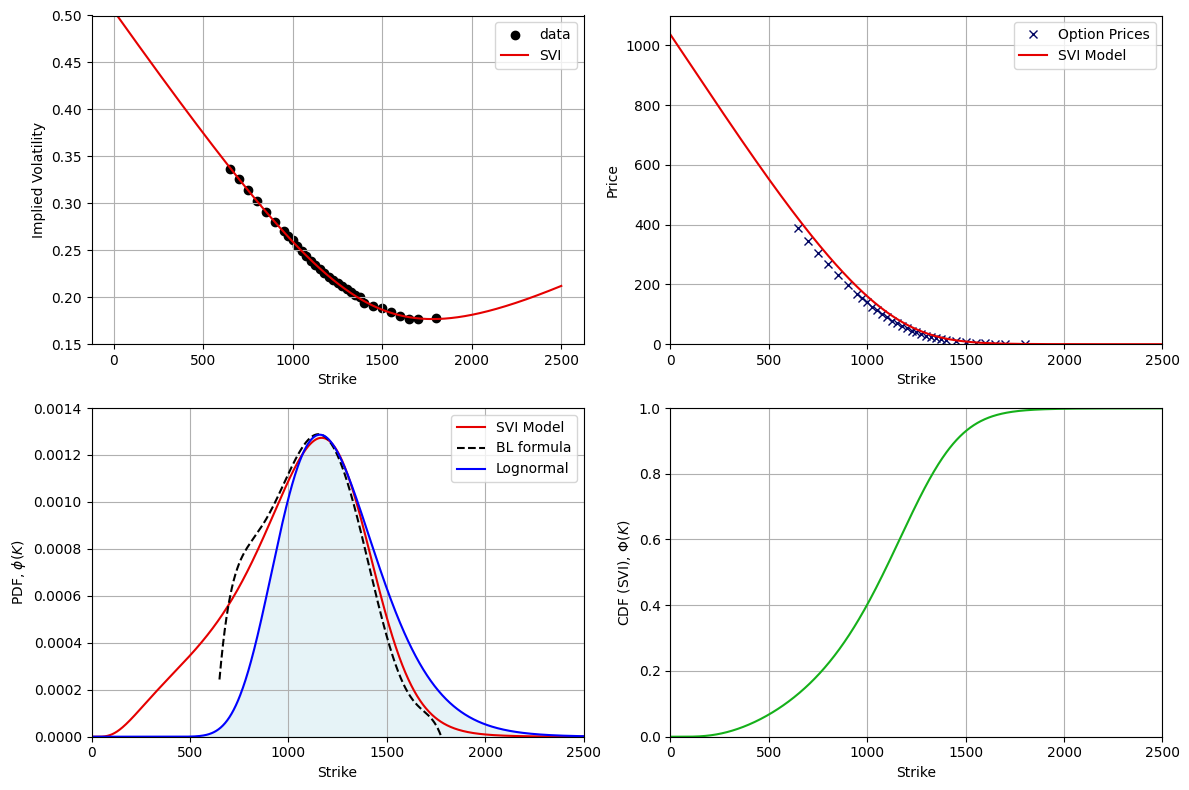

In [71]:
from scipy.stats import lognorm

center = 1160
width = 250
s_param = width / center
scale_param = center * np.exp(s_param**2)
x = np.linspace(center - 5*width, center + 6*width, 1000)
pdf = lognorm.pdf(x, s=s_param, scale=scale_param)*0.825

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.scatter(strikes, vols, label='data', color="black")
plt.plot(x_eval, y_eval, color="xkcd:red", label='SVI')
plt.ylim(0.15, 0.5)
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid(True)

plt.subplot(222)
plt.plot(strikes, prices, 'x', color="xkcd:darkblue", label="Option Prices")
plt.plot(x_eval, sim_prices, color="xkcd:red", label="SVI Model")
plt.xlim(min(x_eval), max(x_eval))
plt.ylim(0., 1100)
plt.grid(True)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.legend()

# plt.plot(in_strikes, d2C)
# plt.plot(in_strikes[arb_indices], d2C[arb_indices], 'rd')
# plt.grid(True)
# plt.title(r'PDF, $\phi(K)$')

plt.subplot(223)
plt.plot(x_eval, d2C_dk2, color="xkcd:red", label="SVI Model")
plt.plot(in_strikes, polynomial(in_strikes), color="xkcd:black", linestyle="--", label="BL formula")
plt.plot(x, pdf, linestyle='-', color="blue", label=f'Lognormal')
plt.fill_between(x, pdf, color='lightblue', alpha=0.3)
plt.xlim(min(x_eval), max(x_eval))
plt.ylim(0, 0.0014)
plt.xlabel("Strike")
plt.ylabel(r'PDF, $\phi(K)$')
plt.grid(True)
plt.legend()

plt.subplot(224)
plt.plot(x_eval, np.cumsum(d2C_dk2*(2500)/1000), color="xkcd:green")
plt.xlim(min(x_eval), max(x_eval))
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel("Strike")
plt.ylabel(r'CDF (SVI), $\Phi(K)$')

plt.tight_layout()
plt.show()

Using the BS formula I can determine a smooth price distribution from the volatilties given by the SVI model.

The "discounted" second derivative gives the risk-neutral distribution as before.

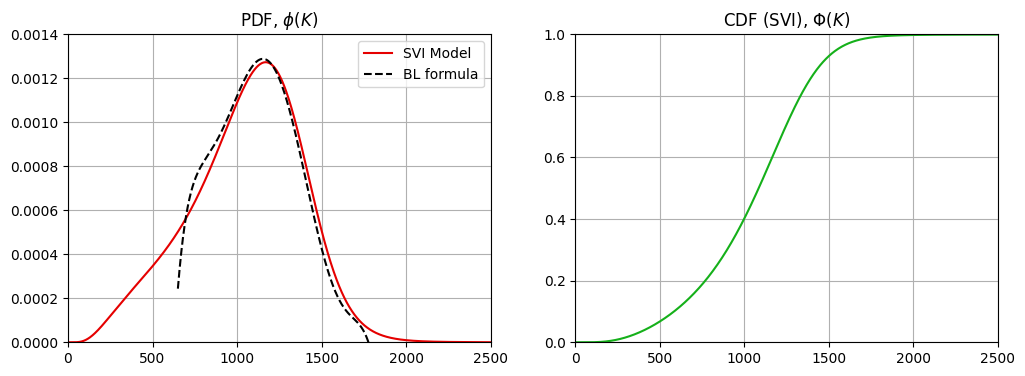

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(x_eval, d2C_dk2, color="xkcd:red", label="SVI Model")
plt.plot(in_strikes, polynomial(in_strikes), color="xkcd:black", linestyle="--", label="BL formula")
plt.xlim(min(x_eval), max(x_eval))
plt.ylim(0, 0.0014)
plt.grid(True)
plt.legend()
plt.title(r'PDF, $\phi(K)$')

plt.subplot(122)
plt.plot(x_eval, np.cumsum(d2C_dk2*(2500)/1000), color="xkcd:green")
plt.xlim(min(x_eval), max(x_eval))
plt.ylim(0, 1)
plt.grid(True)
plt.title(r'CDF (SVI), $\Phi(K)$')
plt.show()

In the common interval of validity the PDF given by the two methods are in very good agreement. The integral of the parametric PDF is now much closer to 1 being able to integrate in a much larger interval of strikes $[0, 2500]$.

### Non-parametric Method

It is also possible to avoid any assumption on the implied volatility distribution, leading to a non-parametric determination of the risk-neutral density.

A first approach consists in using a Kernel Density for the volatility, but it is not trivial to get sensible results.

A more solid approach involve the traing of a neural network model to describe the implied volatility distribution. Once the model has lernt its functional form the algorithm goes on as in the parametric case (price calculation and then numerical derivation of the PDF through the second derivative).

### Dupire Formula and Breeden-Litzenberger

They are essentially two sides of the same coin: one tells you the probability of where the price will end up, while the other tells you how the price must move to get there.

Breeden-Litzenberger: gives you the Risk-Neutral Density (RND) at a specific maturity $T$. It is a "snapshot" of the market's terminal expectations.

Dupire: gives you the Local Volatility, $\sigma_{loc}​(S,t)$, which is the specific diffusion coefficient needed to match all market-observed option prices across all strikes and maturities.

The fundamental link is that the local volatility is the unique diffusion process that makes the evolution of the probability density match the market prices across time.

To understand the connection, we look at how the probability density $f(K,T)$ evolves. In a risk-neutral world, the density follows the Fokker-Planck equation:
$$
\frac{\partial f}{\partial T} = -\frac{\partial}{\partial K}​[rKf]+\frac{1}{2}\frac{\partial^2}{\partial K^2}​[\sigma^2 K^2 f]
$$

Now, recall the Breeden-Litzenberger result: $f(K,T)=e^{rT}\frac{\partial^2 C}{\partial K^2}$​. By substitution and rearranging, you derive the Dupire Equation:
$$
\sigma^2_{loc}​(K,T) =\frac{\frac{\partial C}{\partial T} + rK\frac{\partial C}{\partial K}}{\frac{1}{2}K^2\frac{\partial^2 C}{\partial K^2}}
$$

The denominator in the Dupire formula is exactly the Breeden-Litzenberger term.

This reveals a deep intuition: Local volatility is inversely proportional to the curvature of the option price. If the market assigns a high probability density to a certain strike (high curvature), the local volatility must adjust to ensure the "speed" of the price process is consistent with that density.

Breeden-Litzenberger extracts the destination (the final distribution), while Dupire extracts the map (the local volatility) required to reach that destination while staying consistent with the market.